In [1]:
import numpy as np
import numpy.linalg as nla
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev
from scipy.integrate import quad
from sympy import init_printing, Symbol, Matrix, simplify, lambdify, Array, diff
init_printing()
plt.rc('text', usetex=True)
# from jupyterthemes import jtplot  # this requires jupyterthemes to be installed
# jtplot.style()

In [2]:
plt.rcParams['font.weight'] = 700
plt.rcParams['xtick.top']='True'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.right']='True'
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.labelsize']=22
plt.rcParams['xtick.labelsize']=22
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.minor.size']=3
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.minor.size']=3
plt.rcParams['lines.markersize']=np.sqrt(36)
plt.rc('text',usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath,amsfonts,amssymb,bm}"]

In [3]:
# geometry and material parameters
class geometry():
    def __init__(self, ne, deg):
        self.L = 1.
        self.g = 9.81
        self.A = 10**-4*np.pi
        self.m = 320.
        self.C = 0.
        self.nNNodes=int(ne*deg+1)   #Isoparametric deg-th order lagrange elements
        self.ndim=1
        self.nLNodes=ne+1       #Linear elements
        self.nQNodes=2*ne+1

class GPXi():
    def __init__(self, ordr):
        from numpy.polynomial.legendre import leggauss  #Gauss-Legendre Quadrature for 1D
        self.xi=leggauss(ordr)[0]
        self.wght=leggauss(ordr)[1]

class basis(): # defined on the canonical (master) element (1D : [-1,1] ) 
    def __init__(self,deg,basis_type):
        deg = int(deg)
        if basis_type == 'L':          # 1D Lagrange basis of degree `deg`
            z=Symbol('z')
            Xi=np.linspace(-1,1,deg+1)
            def lag_basis(k):
                n = 1.
                for i in range(len(Xi)):
                    if k != i:
                        n *= (z-Xi[i])/(Xi[k]-Xi[i])
                return n
            N = Array([simplify(lag_basis(m)) for m in range(deg+1)])            
            dfN = diff(N,z)+1.e-25*N
            self.Ns=lambdify(z, N, "numpy")
            self.dN=lambdify(z, dfN, "numpy")
            self.enrich = 1  #enriched dofs (not needed for lagrange elements)
            

In [4]:
def loc_mat(nodes, ElFlag, Ndnode):   #Computes the element quantities when supplied with gloabl nodes
    xi=GP.xi;W=GP.wght
    if etypes=='L':
        x = np.array(nB.Ns(xi)).T @ nodes
        Je = np.array(nB.dN(xi)).T @ nodes
        b1 = np.array(B.Ns(xi)).reshape(-1,1,W.size)
        a1 = np.array(B.dN(xi)).reshape(-1,1,W.size)  
        a2 = a1.reshape(1,len(a1),-1).copy()
        b2 = b1.reshape(1,len(b1),-1).copy()
        a1 *= E(x)/Je*geom.A*W       # multiply by weights, jacobian, A, in bitwise fashion 
        b1 *= geom.C*Je*W
        mat = np.tensordot(a1, a2, axes=([1,2],[0,2])) #+ np.tensordot(b1,b2,axes=([1,2],[0,2]))     #could potentially use einsum to clean it up (but works for now!)
        elemF = (np.array(B.Ns(xi))*W*Je*body_force(x)).sum(axis=1).flatten()
        return mat, elemF

def fsample(x, dof, nodes, sample_type): #giving out the displacement, strain and stress at x: GP and dof value of disp. at gauss point
    #    print(sample_type)
        if sample_type=='spline':
            if int(El[1]) >5:
                k0=5
            else:
                k0 = int(El[1])
                dspl=splrep(nodes,dof,k=k0)
                return (x,splev(x,dspl))
        elif sample_type=='vandermonde':
            Xinew = np.linspace(-1, 1-1.e-13, 20)
            N = np.array(B.Ns(Xinew)).reshape(int(El[-1])+1, Xinew.size,-1)
            N = np.einsum('jik',N)
            Nx = np.array(nB.Ns(Xinew)).reshape(int(MapX[-1])+1,Xinew.size,-1)
            Nx = np.einsum('jik', Nx)
            dofarang = np.vstack((np.arange(k,k+dof.size-1,int(El[-1])) for k in range(int(El[-1])+1))) #arange dofs for multiplication with n
            dofarang=dofarang.reshape(int(El[-1])+1,1,-1)
            xarang = np.vstack((np.arange(k,k+nodes.size-1,int(MapX[-1])) for k in range(int(MapX[-1])+1)))
            xarang = xarang.reshape(int(MapX[-1])+1, 1, -1)
    #        print(dof.shape)
    #        print(nodes.shape)
            dofs=dof[dofarang]
            nodesx=nodes[xarang]
            soln = np.einsum('ikj,kmj->imj',N,dofs)
            xpl = np.einsum('ikj,kmj->imj',Nx,nodesx)
            return (xpl.T.ravel(),soln.T.ravel()) # return the solution evaluated at the given points

In [5]:
def E(x):
    E1 = 200*10**9
    E2 = 70*10**9
    H1 = np.heaviside(x, 0) - np.heaviside(x-0.25, 0)
    H2 = np.heaviside(x-0.25, 0) - np.heaviside(x-0.5, 0)
    H3 = np.heaviside(x-0.5, 0) - np.heaviside(x-0.75, 0)
    H4 = np.heaviside(x-0.75, 0)
    return H1*E1 + H2*E2 + H3*E1 + H4*E2

def rho(x):
    E1 = 7800.
    E2 = 2700.
    H1 = np.heaviside(x, 0) - np.heaviside(x-0.25, 0)
    H2 = np.heaviside(x-0.25, 0) - np.heaviside(x-0.5, 0)
    H3 = np.heaviside(x-0.5, 0) - np.heaviside(x-0.75, 0)
    H4 = np.heaviside(x-0.75, 0)
    return H1*E1 + H2*E2 + H3*E1 + H4*E2

def f(x):
    H = np.heaviside(x-0.375, 0) - np.heaviside(x-0.625, 0)
    return H*10**5*np.cos(4.*np.pi*(x-0.5))

def body_force(x):
    return rho(x)*geom.A*geom.g + f(x)

In [6]:
def uex(x):
    inner = lambda s: rho(s)*geom.A*geom.g + f(s)
    outer = lambda r: 1./(E(r)*geom.A) * (geom.m*geom.g + quad(inner, r, 1., limit=100)[0])
    return quad(outer, 0, x, limit=100 )[0]

def uevec(x):
    kfac = (1.+1.e-17)
    ue1 = lambda x: (0.000303522 - 1.91295*10**-7*x)*x
    ue2 = lambda x: -0.000140877 + (0.000867028 - 1.89193*10**-7*x)*x
    ue3 = lambda x: -5.17856*10**-6 + (0.000505167 - 1.89193*10**-7*x)*x + 0.000028796*np.cos(12.5664*x)
    ue4 = lambda x: 0.000177656 + (0.000176933 - 1.91295*10**-7* x)* x + 0.0000100786*np.cos(12.5664* x)
    ue5 =  lambda x: 0.000256813 + (0.000050282 - 1.91295*10**-7* x)* x
    ue6 = lambda x: 0.000187178 + (0.000143127 - 1.89193*10**-7* x)* x
    H1 = np.heaviside(x,0) - np.heaviside(x-0.25, 0)
    H2 = np.heaviside(x-0.25,0) - np.heaviside(x-0.375, 0)
    H3 = np.heaviside(x-0.375,0) - np.heaviside(x-0.5, 0)
    H4 = np.heaviside(x-0.5, 0) - np.heaviside(x-0.625, 0)
    H5 = np.heaviside(x-0.625, 0) - np.heaviside(x-0.75, 0)
    H6 = np.heaviside(x-0.75, 0)
    uexact = H1*ue1(x) + H2*ue2(x) + H3 * ue3(x) + H4 * ue4(x) + H5 * ue5(x) + H6*ue6(x)
    return uexact

In [15]:
El = "L1"
MapX = "L1"
Nel = 2 #number of elements
Np = 32
etypes = El[0]
if El[0]=='L':                   #1D Mapping function for the physical coordinates
    nB=basis(int(MapX[-1]), MapX[0])
    geom=geometry(Nel, int(MapX[-1])) 
    probsize=geometry(Nel, int(El[-1]))
    B=basis(int(El[-1]), El[0])     #Basis for FE fields (isoparametric) 
    GP=GPXi(Np) 
    nodes = np.linspace(0.,geom.L,geom.nNNodes)
    elems = np.vstack((np.arange(k,k+nodes.size-1, int(MapX[1])) for k in range(int(MapX[1])+1))).T
    globK = 0*np.eye(probsize.nNNodes)   # This changes because now we no longer have iso-p map
    globF = np.zeros(probsize.nNNodes)    
    prescribed_dof=np.array([[0,0]])

dof=np.inf*np.ones(globK.shape[0])
prescribed_forc = np.array([[-1, geom.m*geom.g]])
dof[prescribed_dof[:,0]] = prescribed_dof[:,1]

c:\users\bshri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [16]:
xvals = np.hstack((np.linspace(0,0.25,26),
                   np.linspace(0.25,0.375, 26),
                   np.linspace(0.375, 0.5, 26),
                   np.linspace(0.5, 0.625, 26),
                   np.linspace(0.625, 0.75, 26),
                   np.linspace(0.75, 1, 52)))
xvalsNew = np.linspace(0,1,51)
uevals = uevec(xvals)
# ue = np.array([uex(xv) for xv in xvalsNew], float)

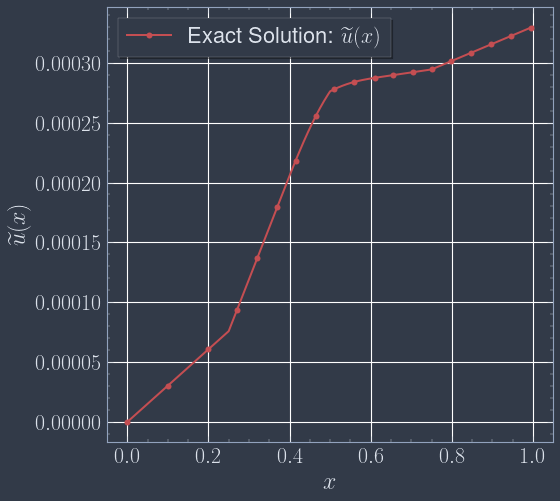

In [17]:
plt.figure(figsize=(8,8))
# plt.plot(xvalsNew, ue, '-b', lw=2)
plt.plot(xvals, uevals, '-ro', lw=2, label=r"Exact Solution: $\widetilde{u}(x)$", markevery=10)
plt.xlabel(r"$x$", fontsize=24)
plt.ylabel(r"$\widetilde{u}(x)$", fontsize=24)
plt.grid(which="major", color="white")
plt.legend(loc=0, fontsize=22, fancybox=False, edgecolor="white", shadow=True)

In [19]:
for k in range(elems[:,0].size): #Assembly of Global System
    elflag = 'nn'
    ndnode = 1
    elnodes=elems[k]
    if etypes=='L':
        elemord=int(El[-1])+1     # basically selecting the corresponding dof
        globdof = np.array([k*(elemord-1)+i for i in range(elemord)], int)
#         print(globdof)
    if etypes != '2D':                                                         # 1D lagrange or legendre polynomials 
        nodexy=nodes[elnodes]
    else:
        nodexy=nodexy[:,elnodes]
    kel, fel = loc_mat(nodexy,elflag,ndnode)
    globK[np.ix_(globdof,globdof)] += kel                                      #this process would change in vectorization 
    globF[globdof] += fel

globF[int(prescribed_forc[:,0])] += prescribed_forc[:,1]    
fdof=dof==np.inf                                                               # free dofs
nfdof=np.invert(fdof)   
if etypes=='L':  
    AA=globK[np.ix_(fdof,fdof)]
    bb=globF[fdof]-globK[np.ix_(fdof,nfdof)] @ dof[nfdof]                                                                           
    dofme=nla.solve(AA, bb)
dof[fdof]=dofme.copy()

In [20]:
xplot=np.linspace(0.,geom.L,10*geom.nNNodes-1)  #sampling points for the exact solution
fittype='vandermonde'
plot_it  = True

c:\users\bshri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
c:\users\bshri\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


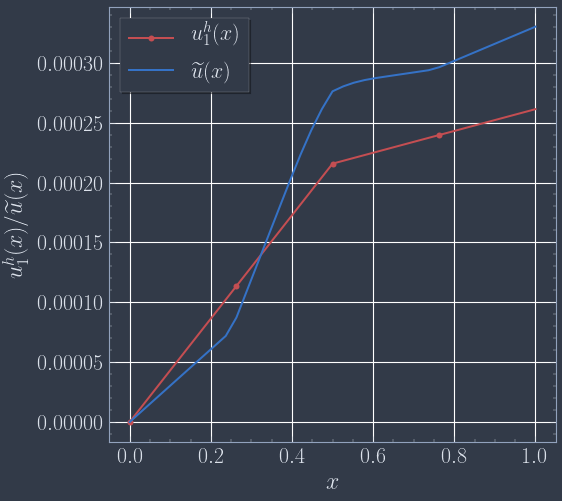

In [21]:
if plot_it:
    if etypes=='L':
        if fittype == 'spline':
            xplot, uapp = fsample(xplot, dof[0:len(dof):int(El[1])], nodes[0:len(nodes):1], fittype)
        elif fittype == 'vandermonde':
            xplot, uapp = fsample(xplot, dof, nodes, fittype)
        plt.figure(figsize=(8,8))
        plt.plot(xplot, uapp,'-ro', lw=2 , label=r'$u^h_{0:1d}(x)$'.format(int(El[-1])), markevery=10)
        plt.plot(xplot, uevec(xplot), "b-", lw=2, label=r"$\widetilde{{u}}(x)$")
        plt.legend(loc=0, fontsize=22, fancybox=False, edgecolor="white", shadow=True)
        plt.ylabel(r"$u^h_{0:1d}(x)/\widetilde{{u}}(x)$".format(int(El[-1])), fontsize=24)
        plt.xlabel(r"$x$", fontsize=24)
        plt.grid(which="major", color="white")